In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
# from geopandas import GeoSeries, GeoDataFrame
import psycopg2 as pg
import requests

%matplotlib inline

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.style.use('ggplot') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

## Analysis of fitness data

In [3]:
# Load fitness data from hla_fitness, this data table stores participant's daily activity.
# This takes time to run
hla_fitness_data_path = 'data/original/hla_fitness.csv'
hla_fitness = pd.read_csv(hla_fitness_data_path,
                          na_values='Nan',
                          parse_dates=['ActivityDate'],
                          dtype={'ParticipantId': np.object})

In [4]:
# Take a look at the structure of the data
hla_fitness.head()

ParticipantId       NRIC ActivityDate  StepCount  Distance  TimeBlock  ActiveTimeTotal  ActiveTimeWalk  ActiveTimeRun  ActiveTimeStairs  ActiveTimeCycle  ActiveTimeOther             CreateAt             UpdateAt Source
0             8  S7414232Z   2014-11-13       6898      5256        0.0             2452            2131              0                 0                0                0  14/11/2014 00:00:00  14/11/2014 00:00:00    NaN
1             8  S7414232Z   2014-11-14      14239     10850        0.0             4896            2871            232                 0                0                0  15/11/2014 00:00:00  15/11/2014 00:00:00    NaN
2             8  S7414232Z   2014-11-15      11579      8823        0.0             1207             685            286                 0                0                0  18/11/2014 00:00:00  18/11/2014 00:00:00    NaN
3             8  S7414232Z   2014-11-17       4518      3442        0.0              193             111              0                 0                0                0  18/11/2014 00:00:00  18/11/2014 00:00:00    NaN
4             8  S7414232Z   2014-11-18      13825     10534        0.0             4858            2079           2051                 0                0                0  19/11/2014 00:00:00  19/11/2014 00:00:00    NaN

In [11]:
hla_fitness.ParticipantId.unique

<bound method IndexOpsMixin.unique of 0                8
1                8
2                8
3                8
4                8
5                8
6                8
7                8
8                8
9                8
10               8
11               8
12               8
13               8
14               8
15               8
16               8
17               8
18               8
19               8
20               8
21               8
22               8
23              11
24              11
25              11
26              11
27              11
28              11
29              11
            ...   
2503322    1204011
2503323    1204011
2503324    1204012
2503325    1204012
2503326    1204012
2503327    1204012
2503328    1204012
2503329    1204012
2503330    1204012
2503331    1204014
2503332    1204014
2503333    1204014
2503334    1204014
2503335    1204014
2503336    1204014
2503337    1204014
2503338    1204021
2503339    1204021
2503340    1204021
2503341    1

In [ ]:
# hla_fitness.head().to_json('test.json',orient='records')

In [5]:
# Filter the acticities by only keeping avtivity with more than 0 distance 
fitness_activity_filtered = hla_fitness[hla_fitness['Distance'] >= 0]

### Total step count by each participant

In [6]:
participant_total_stepcount = fitness_activity_filtered[['ParticipantId',
                                                         'StepCount', 
                                                         'Distance']].groupby('ParticipantId').aggregate(sum).sort_values('StepCount', ascending=False)
participant_total_stepcount.head()

StepCount    Distance
ParticipantId                        
793            1418620395  1929154013
2285              4862445     3705075
4384              4448542     3389726
4486              3497590     2665108
4362              3491981     2657046

### Total step counts by day

In [7]:
# Index the data by ActicityDate
fitness_indexed = fitness_activity_filtered.set_index('ActivityDate')

weekday_stepcount = fitness_activity_filtered[['StepCount', 'Distance']].copy()
weekday_stepcount.loc[:, 'weekday'] = fitness_indexed.index.weekday
weekday_stepcount.head()

StepCount  Distance  weekday
0       6898      5256        3
1      14239     10850        4
2      11579      8823        5
3       4518      3442        0
4      13825     10534        1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1315fcd30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10dedb6d8>], dtype=object)

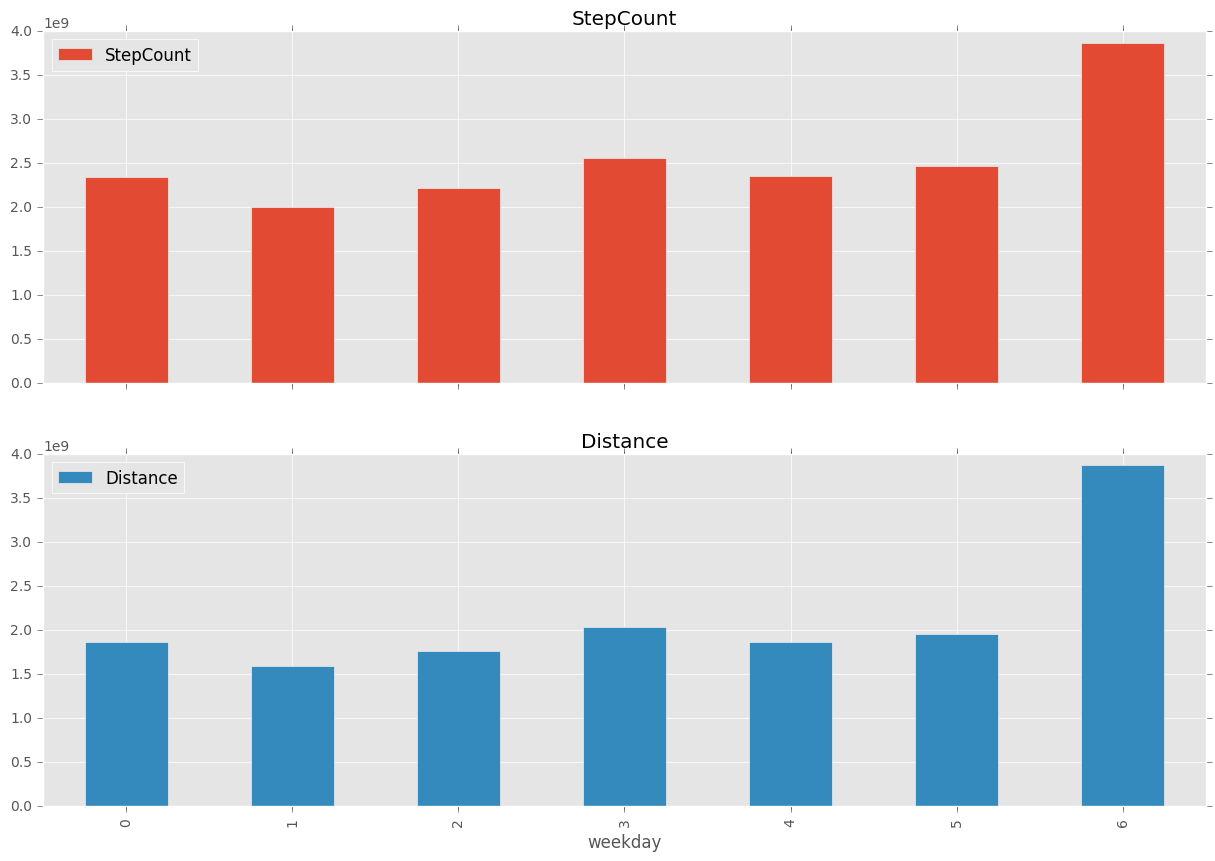

In [8]:
weekday_stepcount.groupby('weekday').aggregate(sum).plot(kind='bar', subplots=True, figsize=(15, 10))

### Widening the fitness activity data

Before widening, each daily activity record for a participant is one row in the original data. Widening is to put a participant's activity records into one row for further analysis

In [9]:
# Extract what's important for analysis [ActivityDate, StepCount, Distance]
fitness_activity_filtered['ActivitySummary'] = list(zip(fitness_activity_filtered.ActivityDate,
                                           fitness_activity_filtered.StepCount))
# Take a look at what's the data is like now
fitness_activity_filtered.head()

/Users/wedrago/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


ParticipantId       NRIC ActivityDate  StepCount  Distance  TimeBlock  ActiveTimeTotal  ActiveTimeWalk  ActiveTimeRun  ActiveTimeStairs  ActiveTimeCycle  ActiveTimeOther             CreateAt             UpdateAt Source               ActivitySummary
0             8  S7414232Z   2014-11-13       6898      5256        0.0             2452            2131              0                 0                0                0  14/11/2014 00:00:00  14/11/2014 00:00:00    NaN   (2014-11-13 00:00:00, 6898)
1             8  S7414232Z   2014-11-14      14239     10850        0.0             4896            2871            232                 0                0                0  15/11/2014 00:00:00  15/11/2014 00:00:00    NaN  (2014-11-14 00:00:00, 14239)
2             8  S7414232Z   2014-11-15      11579      8823        0.0             1207             685            286                 0                0                0  18/11/2014 00:00:00  18/11/2014 00:00:00    NaN  (2014-11-15 00:00:00, 11579)
3             8  S7414232Z   2014-11-17       4518      3442        0.0              193             111              0                 0                0                0  18/11/2014 00:00:00  18/11/2014 00:00:00    NaN   (2014-11-17 00:00:00, 4518)
4             8  S7414232Z   2014-11-18      13825     10534        0.0             4858            2079           2051                 0                0                0  19/11/2014 00:00:00  19/11/2014 00:00:00    NaN  (2014-11-18 00:00:00, 13825)

In [10]:
# Group the fitness acticity data by participant
grouped = fitness_activity_filtered.groupby('ParticipantId')
# Tranform the ActicitySummary series for each participant to a tuple
participant_fitness_acticity_widden = grouped['ActivitySummary'].aggregate(lambda x: tuple(x))
participant_fitness_acticity_widden.head()

ParticipantId
100        ((2015-01-24 00:00:00, 0), (2015-02-17 00:00:0...
1000001    ((2015-12-07 00:00:00, 5037), (2015-07-13 00:0...
1000003    ((2015-12-07 00:00:00, 5037), (2015-07-13 00:0...
1000006                         ((2015-07-20 00:00:00, 17),)
1000008    ((2015-07-13 00:00:00, 6113), (2015-07-14 00:0...
Name: ActivitySummary, dtype: object

In [ ]:
#participant_fitness_acticity_widden.head().to_json('test.json', date_format='iso', orient='index')

In [22]:
#participant_fitness_acticity_widden.to_json('widen.json', date_format='iso', orient='index')

## Analysis of participant data

In [24]:
hla_participant = pd.read_csv('data/original/hla_participant.csv',
                              na_values='Nan',
                              parse_dates=['Birthday', 'CreateAt', 'UpdateAt'],
                              encoding='latin1',
                              dtype={'Id': np.object, 
                                     'MobilePhone': str,
                                     'PostalCode': str})

/Users/wedrago/anaconda/envs/hpb/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
# Take a look at what participant data is like
hla_participant.head()

Id       NRIC   DeviceId  ServiceId PushToken        Name NickName   Birthday Gender MobilePhone                   Email  ResidenceArea PostalCode  Password  MobileOTP  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey   CreateAt            UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight
0   8        NaN  HLA2_0001          1       NaN                  NaN 1984-01-01      F    81232206                     NaN            NaN        NaN       NaN        NaN     0.0     0.0              0                 350                 0            0               0    2.1.0.1       apple   iPhone7;2            0 2014-11-14 2015-12-12 01:52:00        NaN                NaN                NaN           NaN
1  11  S8034644A  HLA2_0001          1       NaN                  NaN 1980-01-01      M    93620299                     NaN            NaN        NaN       NaN        NaN     NaN     NaN              0                 120                 0            0               0          1         HTC     HTC One            0 2014-11-14 2014-11-14 00:00:00        NaN                NaN                NaN           NaN
2  13  S9239849H  HLA2_0001          1       NaN                  NaN 1992-01-01      F    81800228                     NaN            NaN        NaN       NaN        NaN     NaN     NaN              0                  50                 0            0               0      1.0.2       apple   iPhone5;2            0 2014-11-14 2014-11-14 00:00:00        NaN                NaN                NaN           NaN
3  15        NaN  HLA2_0001          1       NaN                  NaN 1981-01-01      F    97350031                     NaN            NaN        NaN       NaN        NaN     0.0     0.0              0                  90                 0            0               0      2.0.7     samsung    GT-I9505            0 2014-11-14 2015-06-10 16:25:00        NaN                NaN                NaN           NaN
4  18        NaN  HLA2_0001          1       NaN  LIMWEILONG      NaN 1991-01-01      M    98189499  limweilong91@gmail.com            NaN        NaN       NaN        NaN     0.0     0.0              0                 120                 0            0               0      1.0.2       apple   iPhone6;2            0 2014-11-14 2015-04-11 16:38:00        NaN                NaN                NaN           NaN

Using default UTF-8 encoding, I got an error saying '"ServiceId, NickName, MobilePhone, PostalCode, TargetCalories, OptInSurvey" has different data type'. 

Then, I found out that one row of data was shifted because of pandas can decode the value of one row, and it failed to parse date as well.

Changed to encoding 'latin1', it works. But columns(6)['NickName'] still has mixed types.

In [ ]:
vhz_participant = pd.read_csv('data/original/vhz_participant-20160808.csv')

### Group by postal code

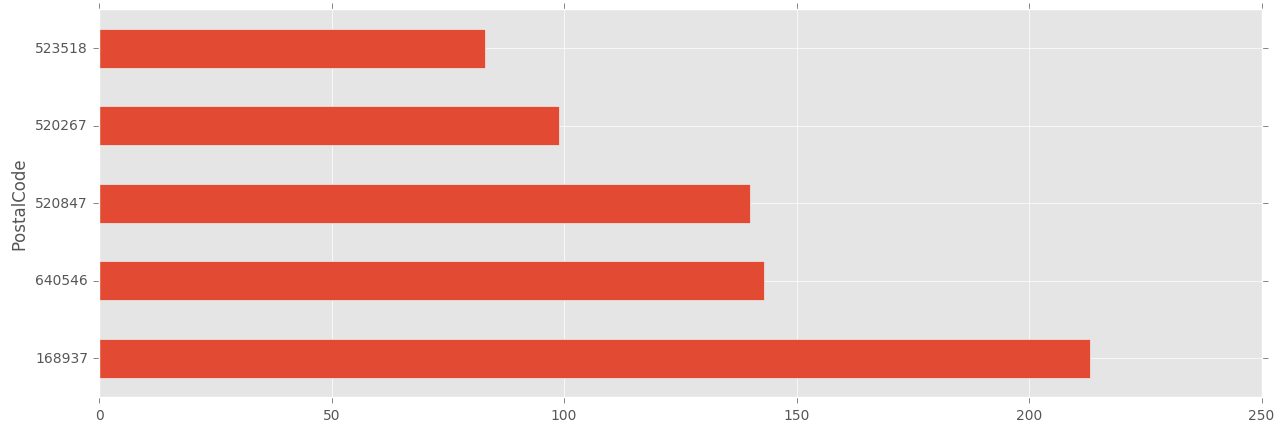

In [28]:
# To find out how many participants are for each postal code
no_participants_per_pc = hla_participant.groupby('PostalCode').size()
no_participants_per_pc.sort_values(ascending=False).head().plot(kind='barh')

## Add more informations to participants dataframe

### Add distance to bus stop

In [33]:
postgis_con = pg.connect(database='vhz', user='postgres', host='localhost')

# Query the distance to the nearst bus stop for each postal code
distance_to_bus_stop_sql = 'select pb_distance.postalcode, min(pb_distance.distance) as min_busstop_distance from (SELECT p.postalcode as postalcode, b.name as stopname, st_distance(p.geoloc, b.geoloc) as distance from postal_code_svy21 p, bus_stop b) as pb_distance GROUP BY pb_distance.postalcode'
bus_stop_distance = pd.read_sql(distance_to_bus_stop_sql, con=postgis_con)
bus_stop_distance.head()

postalcode  min_busstop_distance
0      98202           2322.761541
1     138648            264.614771
2     520472            142.602200
3     733570             42.801398
4     208600             53.558845

In [34]:
# Add the bus stop distance information to participant details table
participant_min_busstopdistance = hla_participant.join(bus_stop_distance.set_index('postalcode'), on='PostalCode')
# Filter out only participant with location infomation
participant_with_loc = participant_min_busstopdistance[participant_min_busstopdistance['min_busstop_distance'].notnull()]

### Add distance to train station

In [41]:
postgis_con = pg.connect(database='vhz', user='postgres', host='localhost')

# Query the distance to the nearst train station for each postal code
distance_to_train_station_sql = 'select pb_distance.postalcode, min(pb_distance.distance) as min_train_distance from (SELECT p.postalcode as postalcode, st_distance(p.geoloc, b.geoloc) as distance from postal_code_svy21 p, train_station b) as pb_distance GROUP BY pb_distance.postalcode;'
train_station_distance = pd.read_sql(distance_to_train_station_sql, con=postgis_con)
train_station_distance.head()

postalcode  min_train_distance
0      98202         3332.159391
1     138648          508.930832
2     520472         1178.758979
3     733570          739.235099
4     208600          476.386714

In [49]:
# Add the bus stop distance information to participant details table
participant_with_loc = participant_with_loc.join(train_station_distance.set_index('postalcode'), on='PostalCode')

### Add total StepCount

In [50]:
# Join with total stepcount table
participant_with_loc_stepcount = participant_with_loc.set_index('Id').join(participant_total_stepcount)

### Add First day, Last Day and Total number of Active days

To find the total number of active day for each participant. This can be used for cleaning the data by filter only active participants. However, how to define a active day is a question to be answered. For now, I just regards days with more than 0 distance is an active day.

In [51]:
participant_no_active_days = grouped.size().to_frame('activedays')

participant_firstday = grouped.ActivityDate.min().to_frame(name='firstday')
participant_lastday = grouped.ActivityDate.max().to_frame(name='lastday')

In [52]:
participant_with_loc_stepcount_activedays = participant_with_loc_stepcount.join(participant_no_active_days)
participant_with_loc_stepcount_activedays = participant_with_loc_stepcount_activedays.join(participant_firstday, rsuffix='first')
participant_with_loc_stepcount_activedays = participant_with_loc_stepcount_activedays.join(participant_lastday, rsuffix='last')

In [53]:
# How to define active day
participant_with_loc_stepcount_activedays.activedays.describe()

count    12224.000000
mean        18.158622
std         18.069257
min          1.000000
25%          7.000000
50%          8.000000
75%         26.000000
max        241.000000
Name: activedays, dtype: float64

## Join analysis of participant and fitness

### Relationship between stepcount and distance

In [54]:
participant_with_loc_stepcount.head()

NRIC        DeviceId  ServiceId PushToken               Name NickName   Birthday Gender MobilePhone                     Email  ResidenceArea PostalCode  Password  MobileOTP  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand     DeviceModel  OptInSurvey   CreateAt            UpdateAt   WearableId WearableAttachedAt WearableDetachedAt  TargetWeight  min_busstop_distance  min_train_distance  StepCount  Distance
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
186        NaN  HLA2_0001_2958          1       NaN        NISHA KUMAR      NaN 1983-01-01      F    94752101  violet_lilac@hotmail.com            NaN     530644       NaN        NaN    80.0   173.0              0                  60                 0            0               0          2     samsung        GT-I9505            0 2014-11-14 2015-09-29 14:26:00          NaN                NaN                NaN           NaN            111.519709         1234.106812    28647.0   21820.0
217        NaN       HLA2_0001          1       NaN           Lorraine      NaN 1980-01-01      F    91075368      rainetan03@gmail.com            NaN     210043       NaN        NaN    56.0   158.0              0                  60                 0            0               0      2.0.1         HTC  HTC Desire 626            0 2014-11-14 2015-11-18 19:58:00          NaN                NaN                NaN          50.0            170.515467          619.982769       11.0       8.0
268  S0125393Z       HLA2_0001          1       NaN             Roy ko      NaN 2049-01-01      M    98300425      koroy@singnet.com.sg            NaN     150086       NaN        NaN    58.0   169.0              0                  15                 0            0               0    2.1.0.1       apple       iPhone7;1            0 2014-11-15 2015-12-18 06:01:00          NaN                NaN                NaN          58.0            122.513937          364.344033        NaN       NaN
315  S1156586G       S1156586G          1       NaN      Huen Moh Kuen      NaN 2056-01-01      F    82334040    chrishuen246@gmail.com            NaN     120723       NaN        NaN     0.0     0.0              0                  60                 0            0               0      2.0.0       KIOSK         iPad4;2            0 2014-11-17 2015-12-23 12:15:00  1.44834E+27     24/11/15 13:09                NaN           NaN             37.724186         1339.065681   348723.0  278148.0
694        NaN       HLA2_0001          1       NaN  Sandy Tan Sze Jia      NaN 1989-01-01      F    98377883        Sandytsj@gmail.com            NaN     530572       NaN        NaN    68.0   169.0              0                  15                 0            0               0      2.0.1       apple       iPhone7;1            0 2014-11-21 2015-11-18 16:45:00          NaN                NaN                NaN          62.0            148.674638          789.573358        NaN       NaN

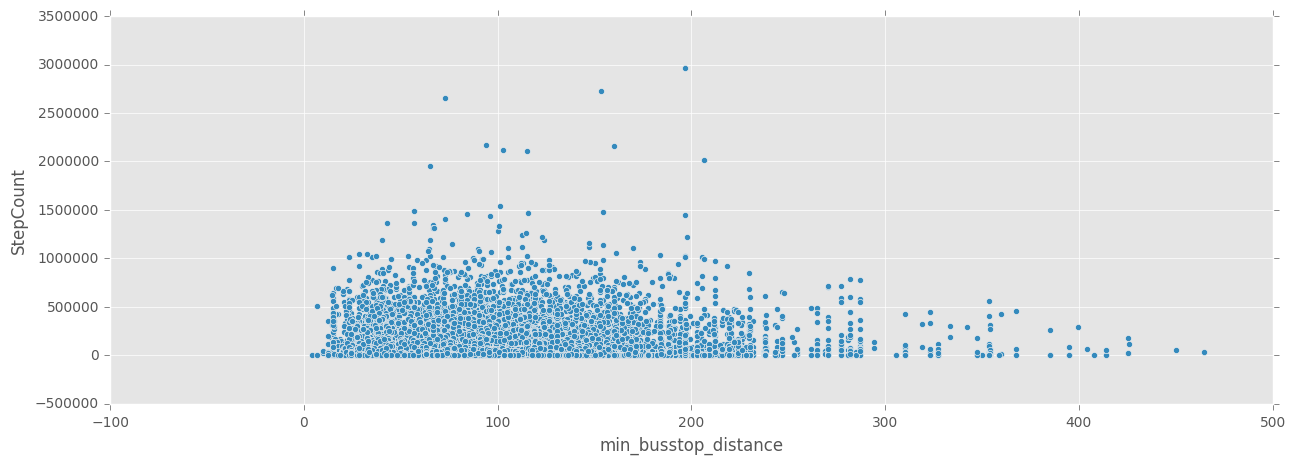

In [47]:
participant_with_loc_stepcount[['min_busstop_distance', 'StepCount']].plot(kind='scatter', x='min_busstop_distance', y='StepCount')

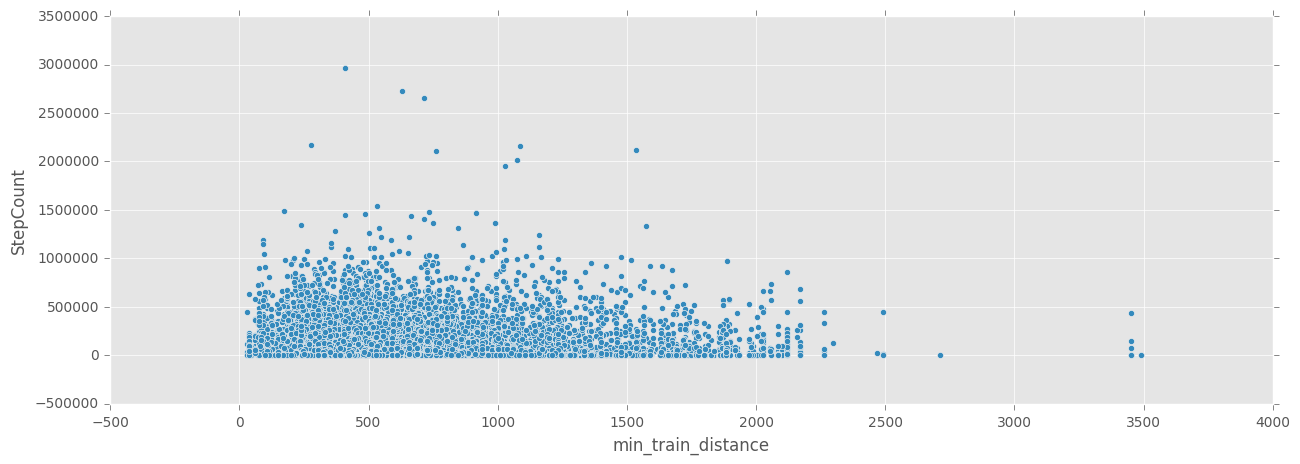

In [55]:
participant_with_loc_stepcount[['min_train_distance', 'StepCount']].plot(kind='scatter', x='min_train_distance', y='StepCount')